### Processing code 3: KB data

In [7]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import date
from datetime import datetime
from dateutil.relativedelta import relativedelta

from pathlib import Path
import random

#AGU Poster code

### Study area

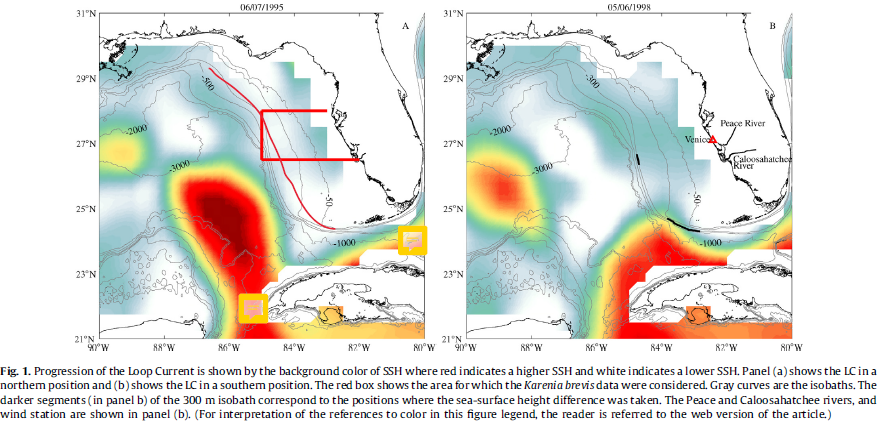
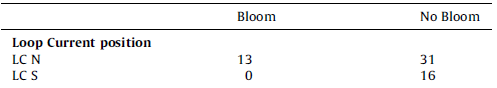
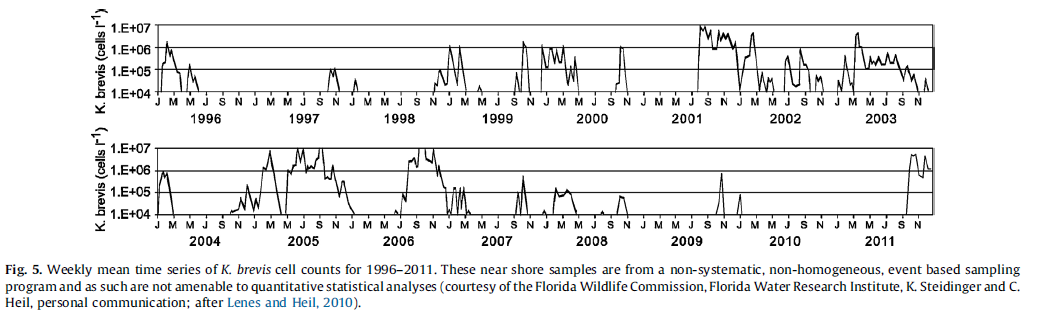

Sample Date: 199301-201412 <br>
Latitude: 26.50	28.00 <br>
Longitude: -85.01	-81.61 <br>
the periods from 1993 to 2007 are considered (15 years 60 periods) <br>
1 degree lat/lon equals 111 km ( 0.1° = 11.1 km)<br>

[113 183]
 [113 184]
 [114 183]
 [115 183]
 [116 183]]
 
 [ 88 203]
 [ 88 204]
 [ 88 205]
 [ 88 206]
 [ 89 200]
 [ 89 201]
 [ 89 202]
 [ 90 197]
 [ 90 198]
 [ 90 199]
 [ 91 196]
 [ 91 197]
 [ 92 194]
 [ 92 195]
 [ 92 196]]

### [1] KB data for the study area from 1993 to 2015

In [8]:
#[1] Read data
df=pd.read_csv('Input/KB_Data.csv')

#[2] Convert date column to a datetime, and set and rename index
df['Sample Date'] = pd.to_datetime(df['Sample Date'])
df.index=df['Sample Date']
df.index.names = ['date']

#[3] Filter study area
df = df[~(df['Latitude'] <26.5)] 
df = df[~(df['Latitude'] >28.0)] 
df = df[~(df['Longitude'] >-81.61)] 
df = df[~(df['Longitude'] <-85.0)] 

#[4] Filter time period of interest 
end_of_year=2014
df=df['1993-1-1':'{}-12-31'.format(end_of_year)]



#[5] Filter variables, and rename variables of interest 
df = df[['Sample Date','Karenia brevis abundance (cells/L)']]
df.columns = ['Sample Date','max_cells/L_raw'] 

#[6] Get number of samples and maximum cell/L per day
samples_count=df['max_cells/L_raw'].groupby(level=0).count()
df=df.groupby(level=0).max()
df['num_of_samples']=samples_count

#[7] Resample to daily data with the maximum cell counts per day
df=df.resample('D').max()

#[8] Save filtered data
df.to_csv('Output/KB_daily_raw_{}.csv'.format(end_of_year))
df['1993-1'].head(5)

,Sample Date,max_cells/L_raw,num_of_samples
date,,,
1993-01-01,1993-01-01,0.0,1.0
1993-01-02,NaT,NaN,NaN
1993-01-03,NaT,NaN,NaN
1993-01-04,1993-01-04,333.0,25.0
1993-01-05,NaT,NaN,NaN


### [2] Karenia bravis and zos data analysis

In [9]:
def plot_KB(data_plot_flag,df,Q,min_bloom_length,max_gaps_days,n_large_blooms,n_large_bloom_periods,bloom_periods_ratio):
    
    #[1] Plot bloom perios 
    #Full data set
    if data_plot_flag==1:
        mask1=df['max_cells/L_raw']>=1e5
        x1=df.index.copy()[mask1]
        y1=df['max_cells/L_raw'].copy()[mask1]
    elif data_plot_flag==2:   
        mask1=Q['max_cells/L_raw']>=1e5
        x1=Q.index.to_timestamp().copy()[mask1]
        y1=Q['max_cells/L_raw'].copy()[mask1]

    #Periods with large blooms
    mask2=Q['n_large_blooms'].notnull()
    x2=Q.index.to_timestamp().copy()[mask2]
    y2=Q['max_cells/L_raw'].copy()[mask2]
    #display(y2)

    #Bar chart 
    fig=plt.figure(figsize=(15,5))
    ax=fig.add_subplot(1,1,1)
    if Period=='Q':
        BarW=92
    elif Period=='2Q':
        BarW=181

    if data_plot_flag==1:
        L1='Period with large-bloom(s) (Length {} - Gaps {})'.format(min_bloom_length,max_gaps_days)
        L2='Daily data with max. K. brevis abundnce above 1e5 cells/L'                                            
        ax.bar(x2,y2,width=BarW,facecolor='red', align='edge',alpha=0.7, label=L1)
        ax.bar(x1,y1,width=0.9,facecolor='green',align='edge', alpha=0.7, label=L2)
    elif data_plot_flag==2:  
        L1='Period with max. K. brevis abundnce above 1e5 cells/L'
        L2='Period with large-bloom(s) (Length {} - Gaps {})'.format(min_bloom_length,max_gaps_days)
        ax.bar(x1,y1,width=BarW,facecolor='green', align='edge', alpha=0.7, label=L1)
        ax.bar(x2,y2,width=BarW,facecolor='red', align='edge', alpha=0.7, label=L2)
    plt.yscale('log')

    #format the x-ticks and labels
    years = mdates.YearLocator()   # every year
    if Period=='Q':
        months = mdates.MonthLocator(bymonth=[1,4,7,10,13])  # every month
    elif Period=='2Q':
        months = mdates.MonthLocator(bymonth=[1,7,13])  # every month
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    #x-axis limit
    Start=1993
    End=end_of_year+1
    start = datetime(year=Start, month=1, day=1, hour=0)
    end   = datetime(year=End, month=1, day=1, hour=0)
    ax.set_xlim(start,end)

    #Axis labels
    #ax.set_xlabel('Periods')
    ax.set_ylabel('Maximum Karenia brevis abundnce (cells/L)')

    #Legend
    ax.legend(loc='best')
    
    #Grid
    #ax.grid(which='major', axis='x')

    #Title
#     title='For a minium bloom length of {} days with a maximum of {}-day gaps (i.e, no data or values below 1e5), \n \
#     the number of large-blooms, number of periods-with-large-bloom(s), ratio of periods-with-large-bloom(s), \
# are {:0.0f}, {} and {:0.2f}, respectively'. \
#     format(min_bloom_length,max_gaps_days,n_large_blooms,n_large_bloom_periods,bloom_periods_ratio)
    title='Large blooms given semi-annual period'
    ax.set_title(title)

    #Display results
    #plt.show()
    #display(Q)
    
    plt.savefig('Output/KB.jpg')

In [18]:
def plot_zos(Period,end_of_year,zos_segment,Q,lat,lon,n_large_bloom_periods,bloom_periods_ratio,NewSeg):
    
    #Plot LC-N and LC-S
    if NewSeg==0:
        zos_period_data_file='Input/zos_period_{}_{}.csv'.format(Period,end_of_year)
    elif NewSeg==1:
        zos_period_data_file='Input/zos_period_{}_{}_10-1.csv'.format(Period,end_of_year)
    elif NewSeg==2:
        zos_period_data_file='Input/zos_period_{}_{}models.csv'.format(Period,end_of_year)
        
    zos=pd.read_csv(zos_period_data_file, index_col='Date', usecols=['Date',zos_segment], date_parser=pd.Period,parse_dates=True)

    #Bar_chart data
    # y=zos[zos_segment].copy()
    # cc=['colors']*len(y)
    # for n,y_i in enumerate(y):
    #     if y_i<0:
    #         cc[n]='green'
    #     elif y_i>=0:
    #         cc[n]='red'    
    y=Q['n_large_blooms']
    cc=['colors']*len(y)
    for n,y_i in enumerate(y):
        if y_i>0:
            cc[n]='red'
        else:
            cc[n]='green'    

    mask_N= [c == 'red' for c in cc]
    x1=zos.index.to_timestamp().copy()[mask_N]
    y1=zos[zos_segment].copy()[mask_N]

    mask_S= [c == 'green' for c in cc]
    x2=zos.index.to_timestamp().copy()[mask_S]
    y2=zos[zos_segment].copy()[mask_S]


    #Plot bar_chart
    fig=plt.figure(figsize=(15,5))
    ax=fig.add_subplot(1,1,1)
    if Period=='Q':
        BarW=92
    elif Period=='2Q':
        BarW=181
    #ax.bar(x1,y1,width=BarW,facecolor='red', align='edge', alpha=0.7, label='Large Bloom')
    #ax.bar(x2,y2,width=BarW,facecolor='green', align='edge', alpha=0.7, label='No Large Bloom')
    ax.bar(x1,y1*100,width=BarW,facecolor='red', align='edge', alpha=0.7, label='Large Bloom')
    ax.bar(x2,y2*100,width=BarW,facecolor='green', align='edge', alpha=0.7, label='No Bloom')

    #format the x-ticks and labels
    years = mdates.YearLocator()   # every year
    if Period=='Q':
        months = mdates.MonthLocator(bymonth=[1,4,7,10,13])  # every month
    elif Period=='2Q':
        months = mdates.MonthLocator(bymonth=[1,7,13])  # every month
    years_fmt = mdates.DateFormatter('%Y')
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)
    ax.xaxis.set_minor_locator(months)

    #x-axis limit
    Start=1993
    End=end_of_year+1
    start = datetime(year=Start, month=1, day=1, hour=0)
    end   = datetime(year=End, month=1, day=1, hour=0)
    ax.set_xlim(start,end)

    #Axis labels
    if NewSeg==2:
        ax.set_xlabel('Periods')
    ax.set_ylabel('delta zos (cm)')

    #Legend
    ax.legend(loc='best')
    
    #Grid
    ax.grid(which='major', axis='x')

    #Title
    if NewSeg==0:
        #ax.set_title('AVISO-phy-001-030 for segment {}_{}'.format(lat,lon))
        ax.set_title('AVISO (phy-001-030) observation data: Loop Current north (+ve values) and south (-ve values)')
        
    elif NewSeg==1:
        ax.set_title('AVISO-phy-001-030 for segment {}_{} \n \
        The number of periods-with-large-bloom(s), and ratio of periods-with-large-bloom(s) are {:0.0f}, and {:0.2f}, respectively'\
        .format(lat,lon,n_large_bloom_periods,bloom_periods_ratio))
    elif NewSeg==2:
        #ax.set_title('Weighted Ensemble Mean for segment {}_{}'.format(lat,lon))
        ax.set_title('ESMs weighted ensemble mean: Loop Current north (+ve values) and south (-ve values)')

    #Display results
    #plt.show()
    plt.savefig('Output/{}.jpg'.format(zos_segment))

Analysis from 1993 to 2014 with rule2 0.2 for period 2Q
min_bloom_length: 10
min-bloom-length 10 days with max-gaps 5 days: large-blooms, periods-with-large-bloom(s), and bloom-periods-ratio are 18, 15, and 0.34


,period,segment,max_gaps_days,min_bloom_length,n_large_blooms,n_large_bloom_periods,LC_N,LC_S,LC_S_ratio,LC_N_NoBloom,LC_N_Bloom,LC_S_NoBloom,LC_S_Bloom,error
Setting,,,,,,,,,,,,,,
Maze,Q,0_0,5.0,10.0,13.0,13.0,44.0,16.0,0.266667,31.0,13.0,16.0,0.0,0.0
2Q_L10G5_S10_1,2Q,10_1,5.0,10.0,18.0,15.0,33.0,11.0,0.25,18.0,15.0,11.0,0.0,0.0


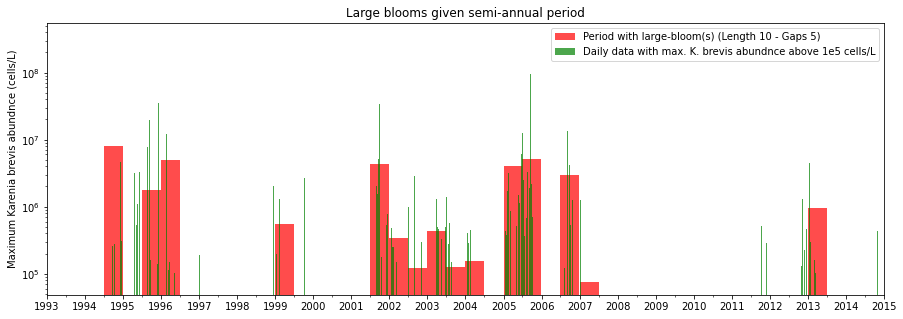

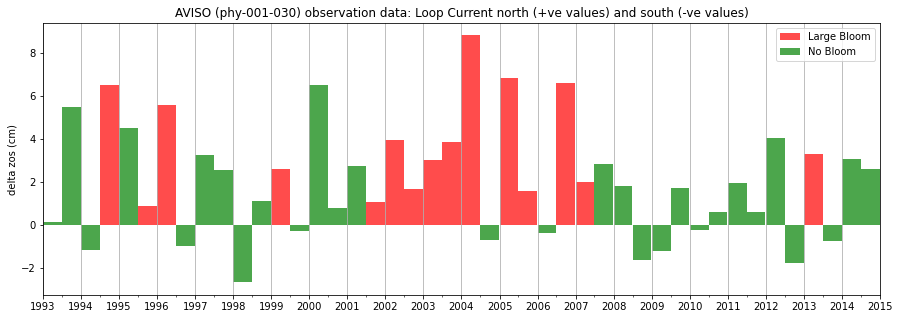

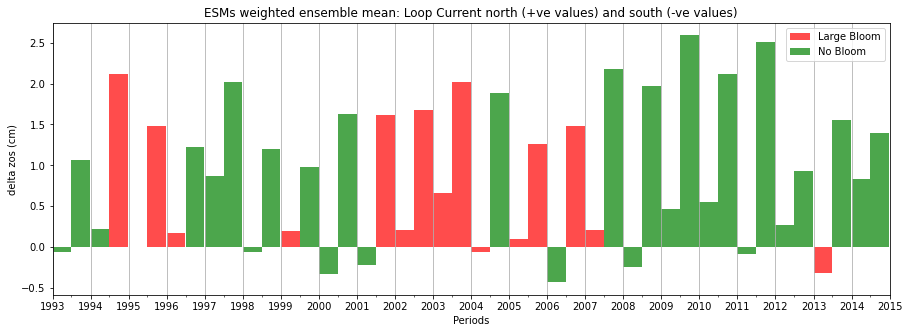

In [19]:
#[0] General
end_of_year=2014
Interpretation=2
rule2=0.2

#Options and flag
data_plot_flag=1    #Raw data plot: [1] daily, [2] period 
Start_KB_df_flag=1  #Start new data frame for saving results
Plot_KB_Flag=1     #[1] Plot KB raw data and bloom analysis 
Save_zos_res_Flag=1  #[1] Save resutls
NewSeg=0

for Period in ['2Q']:
    print('Analysis from 1993 to {} with rule2 {} for period {}'.format(end_of_year,rule2,Period))

    #Part 1: Karenia brevis bloom analysis
    for min_bloom_length in [10]:              #If bloom larger than or equal: 10,14, 15
        print('min_bloom_length:',min_bloom_length)  
        for  max_gaps_days in [5]:              #If gaps more than: 3,4,5,6,7

            #[1] Read data, set index, and select columns of interest 
            df=pd.read_csv('Output/KB_daily_raw_{}.csv'.format(end_of_year))
            df['date'] = pd.to_datetime(df['date'])
            df['Sample Date'] = pd.to_datetime(df['Sample Date'])
            df['idx']=np.arange(len(df))
            df.set_index('date', inplace=True)
            df=df[['idx','Sample Date','num_of_samples','max_cells/L_raw']]

            #[2] Create new dataframe with samples with potential large_bloom
            df['bloom1e5']=df.loc[(df['max_cells/L_raw']>=1e5),'max_cells/L_raw']   #iloc 4

            #[3] Gap between two samples when large bloom is encountered
            bloom_samples=df['bloom1e5'].notnull()
            df.loc[bloom_samples,'gap_days']=df.loc[bloom_samples,'Sample Date'].diff().dt.days-1  #iloc 5

            #[4] Count new blooms with 5 days and 20% rules
            bl=df[bloom_samples].copy()
            bloom=1
            first_bloom=1

            bl['bloom_lenght_inc']=''     #iloc 6
            bl['20%_condition']=''    #iloc 7
            bl['gap']=''              #iloc 8
            bl['new_bloom']=''         #iloc 9
            bl['new_bloom_idx']=''     #iloc 10
            bl.iloc[0,10]=bloom

            for cont in range(0,len(bl)):
                #Start a new blooom
                if first_bloom==1:
                    loc1=0
                    loc2=1
                    idx1=bl.iloc[cont,0]
                    #print('First bloom {} starts at {}'.format(bloom,idx))
                    first_bloom=0
                    sample_count=1
                else:
                    loc2 +=1

                #Add bloom number
                if bl.iloc[cont,5]>max_gaps_days:

                    #bloom length
                    idx2=bl.iloc[cont,0]
                    bl.iloc[cont,6]=idx2-idx1   

                    #20%_condition
                    bl.iloc[cont,7]=bl.iloc[cont,6]*rule2

                    #Gap/Gaps
                    if Interpretation==1:
                        bl.iloc[cont,8]= bl.iloc[cont,5]      
                    elif Interpretation==2:
                        bl.iloc[cont,8]= bl.iloc[loc1:loc2,5].sum() 
                        #print(bl.iloc[cont,8])

                    #Decision: Same bloom
                    if bl.iloc[cont,8] <= bl.iloc[cont,7]:
                        bl.iloc[cont,9]=0

                    #Decision: New bloom
                    elif bl.iloc[cont,8]> bl.iloc[cont,7]:
                        bloom +=1 
                        bl.iloc[cont,9]=1
                        loc1=loc2
                        idx1=bl.iloc[cont,0]

                #New bloom index 
                bl.iloc[cont,10]=bloom

            #[5] Remove blooms less than 10 days 
            bloom_number=0
            bl=bl.resample('D').max()

            for new_bloom_idx in range(1,bloom+1):

                #Filter data for each new bloom
                temp=bl[bl['new_bloom_idx'].eq(new_bloom_idx)]

                #Bloom length days
                idx1=temp.iloc[0,0]
                idx2=temp.iloc[len(temp)-1,0]
                bloom_length=idx2-idx1+1
                if bloom_length>=min_bloom_length:
                    bloom_number+=1

                #Bloom start and end date
                date1=temp[temp['idx']==idx1].index.values
                date2=temp[temp['idx']==idx2].index.values

                #Record bloom number and length 
                if bloom_length>=min_bloom_length:
                    mask=(bl.index >= date1[0]) & (bl.index <= date2[0]) 
                    bl.loc[mask,'bloom_length']=bloom_length
                    bl.loc[mask,'bloom_number']=bloom_number
                    #print(new_bloom_idx,':',idx1,idx2,':',bloom_length,':',pd.to_datetime(date1[0]).date(),pd.to_datetime(date2[0]).date())
                else:
                    bl.loc[date1,'bloom_length']=''

            #[6] Merge dataFrames with no_large bloom and large_bloom and save dataFrame
            df = pd.concat([df, bl], axis=1, sort=False)
            #print(df.columns.values)
            df.columns =['idx', 'Sample Date', 'num_of_samples', 'max_cells/L_raw', 'bloom1e5', \
                     'gap_days', 'idx_b1e5', 'Sample Date', 'num_of_samples_b1e5', 'max_cells/L_raw_b1e5', \
                     'bloom1e5', 'gap_days', 'bloom_lenght_inc', '20%_condition', 'gap', \
                     'new_bloom', 'new_bloom_idx', 'bloom_length', 'bloom_number']

            #[7] Save KB daily output
            df.to_csv('Output/KB_daily_{}.csv'.format(end_of_year))

            #[8] Count number of periods with large_bloom and number of bloom per period 

            #Data per period (Q or 2Q)
            df=df[['max_cells/L_raw','max_cells/L_raw_b1e5','gap','bloom_length','bloom_number']]
            Q=df.resample(Period,kind='period').mean()
            n_periods=len(Q.copy())

            #Count large_bloom and number of bloom per period 
            for period in Q.index.values:

                #Data per period
                data=df[str(period)]

                #Number of blooms per period
                n_blooms=data.loc[data['bloom_number'].notnull(),'bloom_number'].unique()
                Q.loc[str(period),'n_blooms']=len(n_blooms)

                #Analysis of blooms larger than 10 days 
                if len(n_blooms)>0:
                    total_length=0       #total lenght of blooms per period
                    n_large_blooms=0     #number of large blooms 

                    for n_bloom in n_blooms:
                        #Data per bloom
                        mask=data['bloom_number']==n_bloom
                        temp=data.loc[mask,'bloom_number']
                        bloom_lenght=len(temp)

                        #Flag for large blooms
                        if bloom_lenght>=min_bloom_length:
                            #Count large blooms
                            n_large_blooms+=1

                            #Total bloom lenght 
                            total_length=total_length+bloom_lenght

                #Number of large blooms per period and total days of blooms per period
                if len(n_blooms)>0:
                    if n_large_blooms==0:
                        n_large_blooms=np.NaN
                        total_length=np.NaN

                    Q.loc[str(period),'n_large_blooms']=n_large_blooms
                    Q.loc[str(period),'n_days_bloom']=total_length

            #Number of blooms
            n_large_blooms=Q['n_large_blooms'].sum()
            n_large_bloom_periods=Q['n_large_blooms'].count()

            #Ratio of periods with bloom(s) ratio
            bloom_periods_ratio=n_large_bloom_periods/n_periods

            print('min-bloom-length {} days with max-gaps {} days: \
large-blooms, periods-with-large-bloom(s), and bloom-periods-ratio are {:0.0f}, {}, and {:0.2f}' \
                  .format(min_bloom_length,max_gaps_days,n_large_blooms,n_large_bloom_periods,bloom_periods_ratio))

            #[9] Save KB period output 
            Q.to_csv('Output/KB_period_{}{}L{}G{}.csv'.format(Period,end_of_year,min_bloom_length,max_gaps_days))

            #[10] Plot KB blooms
            if Plot_KB_Flag==1:
                plot_KB(data_plot_flag,df,Q,min_bloom_length,max_gaps_days,n_large_blooms,n_large_bloom_periods,bloom_periods_ratio)

    #Part2: zos analysis 

            #[11] zos dataFrames
            #(1) Results summary

            if Start_KB_df_flag==1:
                res=pd.DataFrame({'Setting':['Maze'],'period': ['Q'],'segment': ['0_0'], \
                                  'max_gaps_days':[5], 'min_bloom_length':[10],'n_large_blooms': [13],'n_large_bloom_periods': [13],  \
                                  'LC_N': [44],'LC_S': [16], 'LC_S_ratio': [''],\
                                  'LC_N_NoBloom': [31],'LC_N_Bloom': [13], 'LC_S_NoBloom': [16],'LC_S_Bloom': [0], 'error':[0]})
                res= res.set_index(['Setting'])
                res.loc['Maze','LC_S_ratio']=res.loc['Maze','LC_S']/(res.loc['Maze','LC_S']+res.loc['Maze','LC_N'])
                Start_KB_df_flag=0

            #(2) Delta zos per setting
            df_delta_zos=pd.DataFrame() 


            #[12] zos data analysis
            for lat in range(10,11):      #(-21,21)
            #for lat in ['0']:
                #for lon in ['0']:
                for lon in range(1,2):  #(-21,21)

                    #(0) General info
                    idx='{}_L{}G{}_S{}_{}'.format(Period,min_bloom_length,max_gaps_days,lat,lon)
                    res.loc[idx,'period']=Period
                    res.loc[idx,'min_bloom_length']=min_bloom_length
                    res.loc[idx,'n_large_bloom_periods']=n_large_bloom_periods
                    res.loc[idx,'n_large_blooms']=n_large_blooms
                    res.loc[idx,'max_gaps_days']=max_gaps_days
                    res.loc[idx,'segment']='{}_{}'.format(lat,lon)


                    #(1) Read data, and set index, 
                    if NewSeg==0:
                        folder='AVISIO'
                        data_file='AVISO-1-1_phy-001-030_r0_{}-{}'.format(lat,lon)
                    elif NewSeg==1:
                        folder='per_member_10-1'
                        data_file='AVISO-1-1_phy-001-030_r0'
                        
                    df_zos=pd.read_csv('Input/{}_{}.csv'.format(folder,data_file))
                    df_zos['Date'] = pd.to_datetime(df_zos['Date'])
                    df_zos.set_index('Date', inplace=True)
                    df_zos=df_zos['1993-1-1':'{}-12-31'.format(end_of_year)]

                    #(3)downsampling daily frequency to quarterly-period frequency
                    df_zos=df_zos.resample(Period,kind='period').max()
                    #df_zos.to_csv('KB_data/zos_Data_{}_{}-{}.csv'.format(resample,lat,lon))

                    #(4) Number of north and south Loop Current
                    res.loc[idx,'LC_N']=df_zos['delta'].gt(0).sum()
                    res.loc[idx,'LC_S']=df_zos['delta'].le(0).sum()
                    res.loc[idx,'LC_S_ratio']=res.loc[idx,'LC_S']/(res.loc[idx,'LC_N']+res.loc[idx,'LC_S'])

                    #(5)Save zos delta per setting 
                    Seg='{}_S{}_{}'.format(Period,lat,lon)
                    df_delta_zos[Seg]=df_zos['delta'].copy()

                    #(5)Count LC_S error 
                    QQ=Q.copy()
                    QQ['zos']=df_zos['delta']
                    QQ.dropna(subset=['n_large_blooms'],inplace=True)
                    res.loc[idx,'LC_S_Bloom']=QQ['zos'].lt(0).sum()
                    res.loc[idx,'LC_S_NoBloom']=res.loc[idx,'LC_S']-res.loc[idx,'LC_S_Bloom']
                    res.loc[idx,'LC_N_Bloom']=res.loc[idx,'n_large_bloom_periods']-res.loc[idx,'LC_S_Bloom']
                    res.loc[idx,'LC_N_NoBloom']=res.loc[idx,'LC_N']-res.loc[idx,'LC_N_Bloom']

                    #(6)Error
                    res.loc[idx,'error']=(res.loc[idx,'LC_S_Bloom']/res.loc[idx,'LC_S'])*100

            #[13] Save zos outputs
            if Save_zos_res_Flag==1:
                if NewSeg==0:
                    df_delta_zos.to_csv('Output/zos_period_{}_{}.csv'.format(Period,end_of_year))
                elif NewSeg==1:
                    df_delta_zos.to_csv('Output/zos_period_{}_{}_10-1.csv'.format(Period,end_of_year))
                
            #(6) Plot zos for LC-N and LC-S  
            zos_segment='{}_S{}_{}'.format(Period,lat,lon)  #e.g. Q_S6_4, 2Q_S0_0
            plot_zos(Period,end_of_year,zos_segment,Q,lat,lon,n_large_bloom_periods,bloom_periods_ratio,NewSeg)
            
            #(6) Plot zos for LC-N and LC-S  
            zos_segment='{}_S{}_{}'.format(Period,0,0)  #e.g. Q_S6_4, 2Q_S0_0
            NewSeg=2
            plot_zos(Period,end_of_year,zos_segment,Q,lat,lon,n_large_bloom_periods,bloom_periods_ratio,NewSeg)
            
            


#[14] Save summary results of KB and zos analysis 
if Save_zos_res_Flag==1:
    if NewSeg==0:
        res.to_csv('Output/results_{}.csv'.format(end_of_year))
    elif NewSeg==1:
        res.to_csv('Output/results_{}_10-1.csv'.format(end_of_year))
display(res)